In [1]:
import numpy as np
import csv
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
#from tensorflow.examples.tutorials.mnist import input_data
from torch.autograd import Variable
import sklearn.metrics as metrics
import pickle
import os

In [2]:
with open('screen_info.txt','rb') as fl:
    t = pickle.load(fl)
fnames = t[0]
totf = t[1]
binf = t[2]
runfile = 0
fname = fnames[runfile]
bf = binf[runfile]

In [3]:
path = os.getcwd() + '/bioassay-datasets/'
test_bin = []
test_con = []
labels = []
with open(path+fname+'red_test.csv') as csvfile:
    readcsv = csv.reader(csvfile)
    for row in readcsv:
        test_bin.append(row[:bf])
        test_con.append(row[bf:-1])
        labels.append(row[-1])

In [4]:
test_bin = np.asarray(test_bin)[1:]
test_bin = test_bin.astype(int)
test_bin[test_bin==0] = -1

test_con = np.asarray(test_con)[1:]
test_con = test_con.astype(float)

#Normalise the features
test_con = (test_con - np.mean(test_con,axis=0))/np.std(test_con,axis=0)

test_whole = np.concatenate((test_bin,test_con),axis=1)

#p2_fingerprints = np.ones(p_fingerprints.shape)
(no_examples , ip_dim1) = test_bin.shape
ip_dim2 = test_con.shape[1]
labels = labels[1:]
print(no_examples,ip_dim1)
print(ip_dim2)
test_bin[(test_bin==0)] = -1
ip_dim = test_whole.shape[1]

(856, 112)
32


In [5]:
h1_dim = 500
h2_dim = 500
h3_dim = 500
z_dim = 60
X_dim = ip_dim1

In [6]:
test_labels2 = np.zeros((len(labels),1))
for i,l in enumerate(labels):
    if l=='Active':
        test_labels2[i] = 1
    else:
        test_labels2[i] = 0
test_labels2 = test_labels2.astype(int)
total_pos = np.sum(test_labels2)
print("tot_positive",total_pos)

('tot_positive', 12)


In [7]:
class full_mlp(nn.Module):
    def __init__(self):
        super(full_mlp,self).__init__()
        self.l1 = nn.Linear(ip_dim,500)
        self.l2 = nn.Linear(500,500)
        self.l3 = nn.Linear(500,250)
        self.l4 = nn.Linear(250,50)
        self.l5 = nn.Linear(50,2)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.leaky_relu(self.l4(x))
        x = (self.l5(x))
        
        return x

In [8]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder,self).__init__()
        self.l1 = nn.Linear(X_dim,h1_dim)
        self.l2 = nn.Linear(h1_dim,h2_dim)
        self.l3 = nn.Linear(h2_dim,h3_dim)
        self.l4 = nn.Linear(h3_dim,z_dim)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = self.l4(x)
        
        return x

In [9]:
class DiscriminatorAE(nn.Module):
    def __init__(self):
        super(DiscriminatorAE,self).__init__()
        self.l1 = nn.Linear(z_dim,200)
        self.l2 = nn.Linear(200,200)
        self.l3 = nn.Linear(200,100)
        self.l4 = nn.Linear(100,70)
        self.l5 = nn.Linear(70,2)
        
    def forward(self,x):
        x = F.selu(self.l1(x))
        x = F.selu(self.l2(x))
        x = F.selu(self.l3(x))
        x = F.relu(self.l4(x))
        x = (self.l5(x))
        
        return x

In [10]:
class b_mlp(nn.Module):
    def __init__(self):
        super(b_mlp,self).__init__()
        self.l1 = nn.Linear(ip_dim1,1000)
        self.l2 = nn.Linear(1000,500)
        self.l3 = nn.Linear(500,200)
        self.l4 = nn.Linear(200,2)
        
    def forward(self,x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = (self.l4(x))
        
        return x

In [11]:
class c_mlp(nn.Module):
    def __init__(self):
        super(c_mlp,self).__init__()
        self.l1 = nn.Linear(ip_dim2,100)
        self.l2 = nn.Linear(100,100)
        #self.l3 = nn.Linear(100,100)
        self.l4 = nn.Linear(100,50)
        self.l5 = nn.Linear(50,2)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        #x = F.leaky_relu(self.l3(x))
        x = F.leaky_relu(self.l4(x))
        x = (self.l5(x))
        
        return x

In [12]:
b_mlp1 = b_mlp().cuda()
path1 = os.getcwd() + '/b_model_with_val_selu'
b_mlp1.load_state_dict(torch.load(path1))

b_test_op = b_mlp1(Variable(torch.cuda.FloatTensor(test_bin)))
b_test_op = b_test_op.cpu().data.numpy()
b_test_pred = np.argmax(b_test_op,axis=1)

In [13]:
c_mlp1 = c_mlp().cuda() 
path2 = os.getcwd() +  '/cont_model_with_val_selu'
c_mlp1.load_state_dict(torch.load(path2))

c_test_op = c_mlp1(Variable(torch.cuda.FloatTensor(test_con)))
c_test_op = c_test_op.cpu().data.numpy()
c_test_pred = np.argmax(c_test_op,axis=1)

In [14]:
path3 = os.getcwd() + '/model_autoencoder_' + str(fname)
path4 = os.getcwd() + '/model_enc_' + str(fname)
ae_enc = encoder().cuda()
ae_disc = DiscriminatorAE().cuda()
ae_enc.load_state_dict(torch.load(path4))
ae_disc.load_state_dict(torch.load(path3))

ae_test_z = ae_enc(Variable(torch.cuda.FloatTensor(test_bin)))
ae_op = ae_disc(ae_test_z)
ae_op = ae_op.cpu().data.numpy()
ae_pred = np.argmax(ae_op,axis=1)

In [15]:
f_mlp = full_mlp().cuda()
path5 = os.getcwd() + '/model_all_feat_file' + fname
f_mlp.load_state_dict(torch.load(path5))

f_test_op = f_mlp(Variable(torch.cuda.FloatTensor(test_whole)))
f_test_op = f_test_op.cpu().data.numpy()
f_test_pred = np.argmax(f_test_op,axis=1)

In [19]:
test_pred = f_test_pred
test_pred[test_pred >= 1] = 1
t_cf = metrics.confusion_matrix(test_labels2,test_pred).ravel()
[tn, fp, fn, tp] = t_cf

print('tn, fp, fn, tp: ',t_cf)

('tn, fp, fn, tp: ', array([832,  12,   8,   4]))


In [43]:
fpara = []
for param in f_mlp.parameters():
    #print param.data.size()
    fpara.append(param.cpu().data.numpy())

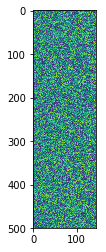

In [48]:
from matplotlib import pyplot as plt
plt.imshow(fpara[0])
plt.show()

In [50]:
bpara = []
for param in b_mlp1.parameters():
    #print param.data.size()
    bpara.append(param.cpu().data.numpy())

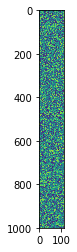

In [51]:
plt.imshow(bpara[0])
plt.show()

In [52]:
cpara = []
for param in c_mlp1.parameters():
    cpara.append(param.cpu().data.numpy())

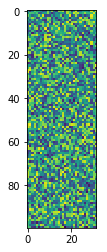

In [53]:
plt.imshow(cpara[0])
plt.show()

In [55]:
[fm,cm,bm] = [np.mean(fpara[0]),np.mean(cpara[0]),np.mean(bpara[0])]

In [56]:
print(fm,cm,bm)

(-0.0010652386, 0.00077045354, -0.00046723647)


In [57]:
[fs,cs,bs] = [np.std(fpara[0]),np.std(cpara[0]),np.std(bpara[0])]

In [58]:
print(fs,cs,bs)

(0.048770692, 0.106681, 0.054789938)
